In [1]:
!wget https://raw.githubusercontent.com/Mehrdadghassabi/Gracc/master/BCSThesis/Source/circuits/circuit1.txt
!wget https://raw.githubusercontent.com/Mehrdadghassabi/Gracc/master/BCSThesis/Source/circuits/circuit2.txt

--2022-07-24 07:38:35--  https://raw.githubusercontent.com/Mehrdadghassabi/Gracc/master/BCSThesis/Source/circuits/circuit1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71 [text/plain]
Saving to: ‘circuit1.txt’

circuit1.txt        100%[===================>]      71  --.-KB/s    in 0s      

2022-07-24 07:38:35 (2.36 MB/s) - ‘circuit1.txt’ saved [71/71]

--2022-07-24 07:38:35--  https://raw.githubusercontent.com/Mehrdadghassabi/Gracc/master/BCSThesis/Source/circuits/circuit2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
from scipy import linalg
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [3]:
# with special thanks to https://github.com/WarrenWeckesser/odeintw
# Tuple holding the major and minor versions of numpy.
_NUMPY_VERSION = tuple(int(d) for d in np.__version__.split('.')[:2])

if _NUMPY_VERSION >= (1, 7):
    _astype_kwargs = {'copy': False}
else:
    _astype_kwargs = {}

In [4]:
def _check_args(kwargs):
    """
    Check for arguments that are not supported with array differential
    equations.
    """
    _unsupported_odeint_args = ['col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintw for array differential equations." %
                         (bad_args[0],))

In [5]:
def _float64_view_of_complex128(z):
    return np.atleast_1d(z).astype(np.complex128).view(np.float64)

In [6]:
def _complex_to_real_jac(jac):
    real_jac = np.empty((2*jac.shape[0], 2*jac.shape[1]))
    real_jac[0::2, 0::2] = jac.real
    real_jac[1::2, 1::2] = jac.real
    real_jac[0::2, 1::2] = -jac.imag
    real_jac[1::2, 0::2] = jac.imag
    return real_jac

In [7]:
def _transform_banded_jac(bjac):
    # Shift every other column.
    newjac = np.zeros((bjac.shape[0] + 1, bjac.shape[1]))
    newjac[1:, ::2] = bjac[:, ::2]
    newjac[:-1, 1::2] = bjac[:, 1::2]
    return newjac

In [8]:
def odeintw(func, y0, t, **kwargs):
    full_output = kwargs.get('full_output', False)
    tfirst = kwargs.get('tfirst', False)
    Dfun = kwargs.pop('Dfun', None)

    y0 = np.atleast_1d(y0)
    shape = y0.shape

    if y0.ndim == 1:
        func1 = func
        jacfunc1 = Dfun
    else:
        # y0 has dimension greater than 1.
        _check_args(kwargs)

        # Flatten y0, and create a wrapper for func that can be used
        # by odeint.
        y0 = y0.ravel()

        if tfirst:
            def vecfunc(t, y, *args):
                a = y.reshape(shape)
                dadt = func(t, a, *args)
                return np.asarray(dadt).ravel()
        else:
            def vecfunc(y, t, *args):
                a = y.reshape(shape)
                dadt = func(a, t, *args)
                return np.asarray(dadt).ravel()

        func1 = vecfunc

        if Dfun is not None:

            if tfirst:
                def jacfunc(t, y, *args):
                    a = y.reshape(shape)
                    jac = Dfun(t, a, *args)
                    return np.asarray(jac).reshape(y0.size, y0.size)
            else:
                def jacfunc(y, t, *args):
                    a = y.reshape(shape)
                    jac = Dfun(a, t, *args)
                    return np.asarray(jac).reshape(y0.size, y0.size)

            jacfunc1 = jacfunc
        else:
            jacfunc1 = None

    if not np.iscomplexobj(y0):
        y0 = y0.astype(np.float64, **_astype_kwargs)
        func2 = func1
        jacfunc2 = jacfunc1
    else:
        # y0 is complex.
        col_deriv = kwargs.pop('col_deriv', False)
        ml = kwargs.pop('ml', None)
        mu = kwargs.pop('mu', None)
        kwargs['ml'] = None if ml is None else 1 + 2*ml
        kwargs['mu'] = None if mu is None else 1 + 2*mu

        # Cast y0 to np.complex128.
        y0 = y0.astype(np.complex128, **_astype_kwargs)

        # realfunc is a wrapper of the user's function that can be
        # used by odeint.
        if tfirst:
            def realfunc(t, y, *args):
                z = y.view(np.complex128)
                dzdt = func1(t, z, *args)
                # func1 might return a python list, or a scalar, so convert
                # it to a float64 view of a complex128 array.
                dydt = _float64_view_of_complex128(dzdt)
                return dydt
        else:
            def realfunc(y, t, *args):
                z = y.view(np.complex128)
                dzdt = func1(z, t, *args)
                # func1 might return a python list, or a scalar, so convert
                # it to a float64 view of a complex128 array.
                dydt = _float64_view_of_complex128(dzdt)
                return dydt

        func2 = realfunc

        if jacfunc1 is not None:

            if tfirst:
                def jacfuncz(t, y, *args):
                    z = y.view(np.complex128)
                    jac = jacfunc1(t, z, *args)
                    if col_deriv:
                        # If col_deriv is True, transpose the result returned
                        # by jacfunc1, and continue as if col_deriv was False.
                        jac = jac.T
                    # Convert jac to real_jac, an array in which each complex
                    # value a+i*b in jac is expanded to the 2x2 array
                    # [[a, -b], [b, a]].
                    real_jac = _complex_to_real_jac(jac)
                    if ml is not None or mu is not None:
                        # Banded; shift every other column up one.
                        real_jac = _transform_banded_jac(real_jac)
                    return real_jac
            else:
                def jacfuncz(y, t, *args):
                    z = y.view(np.complex128)
                    jac = jacfunc1(z, t, *args)
                    if col_deriv:
                        # If col_deriv is True, transpose the result returned
                        # by jacfunc1, and continue as if col_deriv was False.
                        jac = jac.T
                    # Convert jac to real_jac, an array in which each complex
                    # value  a+i*b in jac is expanded to the 2x2 array
                    # [[a, -b], [b, a]].
                    real_jac = _complex_to_real_jac(jac)
                    if ml is not None or mu is not None:
                        # Banded; shift every other column up one.
                        real_jac = _transform_banded_jac(real_jac)
                    return real_jac

            jacfunc2 = jacfuncz
        else:
            jacfunc2 = None

    # Call scipy.integrate.odeint with our wrapper.
    result = odeint(func2, y0.view(np.float64), t, Dfun=jacfunc2, **kwargs)

    if full_output:
        sol, infodict = result
    else:
        sol = result

    if np.iscomplexobj(y0):
        # Restore the complex view.
        sol = sol.view(np.complex128)

    # Restore the shape.
    sol = sol.reshape(-1, *shape)

    if full_output:
        result = (sol, infodict)
    else:
        result = sol
    return result

In [9]:
def asys(x, t, a):
    return a.dot(x)

In [12]:
def plot_weight_function():
    a = np.array([[-0.5]])
    t = np.linspace(0, 10, 201)

    # x0 is the initial condition.
    x0 = np.array([[7.0]])

    sol = odeintw(asys, x0, t, args=(a,))

    plt.figure(1)
    plt.clf()
    color1 = (0.5, 0.4, 0.3)
    color2 = (0.2, 0.2, 1.0)
    plt.plot(t, sol[:, 0, 0], color=color1, label='x[0,0]')
    # plt.plot(t, sol[:, 0, 1], color=color2, label='x[0,1]')
    # plt.plot(t, sol[:, 1, 0], '--', color=color1, linewidth=1.5, label='x[1,0]')
    # plt.plot(t, sol[:, 1, 1], '--', color=color2, linewidth=1.5, label='x[1,1]')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

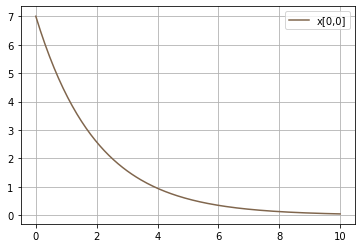

In [13]:
plot_weight_function()

In [14]:
def str_on_edge(a,b,c,d):
    s = ''
    if not a == 0 :
       s = s + str(a) + 'Ohms '
    if not b == 0 :
       s = s + str(b) + 'Volts '
    if not c == 0 :
       s = s + str(c) + 'Farad '
    if not d == 0 :
       s = s + str(d) + 'Henry '
    return s

In [15]:
def print_sug_dir(vals):
    for val in vals :
        s = '[' + str(val[0]) + ']' + '---->' + '[' + str(val[1]) + ']'
        print(s)

In [16]:
# this function get the example circuit information
# from .txt file by parsing it
# 
# returns kirchoff graph as the result
def circuit_parser(circ):
     nodesnumber = 0
     edgesnumber = 0
     kgedgatt = {}
     kgnodatt = {}
     i = 0
     # i is the loop variable
     with open(circ) as f:
         for line in f:
            # for each line in the .txt file get the line number i
            omitnewlines = line.replace('\n', '')
            # remove newlines
            arrstr = omitnewlines.split(" ")
            arrnum = [float(numeric_string) for numeric_string in arrstr]
            # in each lines there are some numbers
            # convert the line which is a string to array of numbers
            if i == 0 :
              # if its the first line it determines 
              # number of nodes & edges
              nodesnumber = int(arrnum[0])
              edgesnumber = int(arrnum[1])
              kgam = np.zeros([nodesnumber,nodesnumber], dtype=float)
            else :
              # else it means that this line is an information about an edge
              # the origin and the destanation node
              # & information that an edge contains
              xmat = int(arrnum[0])
              ymat = int(arrnum[1])

              Coord = (xmat,ymat)
              kgam[xmat][ymat] = 1
   
              att_of_edge = {}
              att_of_edge['resistor'] = arrnum[2]
              att_of_edge['battery'] = arrnum[3]
              att_of_edge['capacitor'] = arrnum[4]
              att_of_edge['self'] = arrnum[5]
              att_of_edge['suggested_dir'] = Coord
              att_of_edge['whole'] = str_on_edge(arrnum[2],arrnum[3],
                                                 arrnum[4],arrnum[5])

              kgedgatt[Coord] = att_of_edge
            i = i + 1
     df = pd.DataFrame(kgam)
     kg = nx.from_pandas_adjacency(df)
     nx.set_edge_attributes(kg, kgedgatt)
     return kg

In [17]:
def plot_kirchoffgraph(kg):
    pos = nx.spring_layout(kg)
    nx.draw(kg, pos, with_labels=True, node_color='#FF0000')
    edge_labels = nx.get_edge_attributes(kg,'whole')
    nx.draw_networkx_edge_labels(kg, pos, edge_labels)
    plt.show()
    print_sug_dir(nx.get_edge_attributes(kg,'suggested_dir').values())

In [18]:
# this function takes kirchoff graph & minimum spaning tree
# and returns edges that eliminated 
# from kirchoff graph to build its minimum spaning tree
#
# kirchoff graph minimum spaning tree + eliminated edges = kirchoff graph 
def Eliminated_Edges(kgam,kgmstam):
    nodesnumber = len(kgam)
    l = []
    for i in range(nodesnumber):
       for j in range(nodesnumber):
           if kgam[i][j] == 1 and kgmstam[i][j]== 0 :
              if [j,i] not in l :
                 l.append([i,j])
    return np.array(l)

In [19]:
# by removing some edges from kirchoff graph
# we calculated minimum spaning tree
# for finding fundemental cycles of kirchoff graph
# we need to restore eliminated edges one by one
# and create list of graph (for more description read the doc)
# 
# this function takes minimum spaning tree (kgmst)
#  & eliminated edges as input
# and return the list that mentioned above
def graph_list(kgmstam,eled):
    i = 0
    glam = np.zeros([len(eled),len(kgmstam),len(kgmstam)], dtype=int)
    gl = []
    for edge in eled :
        glam[i] = kgmstam
        glam[i][edge[0]][edge[1]] = 1
        glam[i][edge[1]][edge[0]] = 1
        i = i + 1
    for am in glam :
        df = pd.DataFrame(am)
        g = nx.from_pandas_adjacency(df)
        gl.append(g)
    return gl
        

In [20]:
# this function get graph list as input
# and returns kirchoff graph fundamental cycles as list
def find_fundamental_cycles(gl) :
    fcl = []
    for g in gl :
        try:
           fcl.append(nx.find_cycle(g, orientation="ignore"))
        except nx.exception.NetworkXNoCycle:
           continue
    return fcl


In [21]:
def isstraight(org,dst,suggested_dir):
    return (suggested_dir[0] == org) and (suggested_dir[1] == dst)

In [22]:
def get_A_coord(kg,org,dst):
    edges = kg.edges()
    i = 0 
    for edge in kg.edges():
        c1 = edge[0] == org and edge[1] == dst
        c2 = edge[1] == org and edge[0] == dst
        if c1 or c2 :
           return i
        i = i + 1

In [23]:
def find_kg_edges_weights(kg):
    kgmst = nx.minimum_spanning_tree(kg)
    kgmstam = nx.to_numpy_array(kgmst).astype(int)
    kgam = nx.to_numpy_array(kg).astype(int)
    eled = Eliminated_Edges(kgam,kgmstam)
    gl = graph_list(kgmstam,eled)
    fcl = find_fundamental_cycles(gl)
    edge_number = kg.number_of_edges()
    B = np.zeros([edge_number,1])
    A = np.zeros([edge_number,edge_number])
    i = 0
    for cycle in fcl :
        volsum = 0
        res = 0
        for edge in cycle :
            org = edge[0]
            dst = edge[1]
            sugdir = kg.get_edge_data(org,dst)['suggested_dir']
            if isstraight(org,dst,sugdir) :
               volsum = volsum - kg.get_edge_data(org,dst)['battery']
               res = -kg.get_edge_data(org,dst)['resistor']
               cor = get_A_coord(kg,org,dst)
               A[i][cor] = res
            else :
               volsum = volsum + kg.get_edge_data(org,dst)['battery']
               res = +kg.get_edge_data(org,dst)['resistor']
               cor = get_A_coord(kg,org,dst)
               A[i][cor] = res
        B[i][0]= volsum
        i = i + 1
    for node in kg.nodes :
        for nei in kg.neighbors(node):
            sugdir = kg.get_edge_data(node,nei)['suggested_dir']
            inr = isstraight(node,nei,sugdir)
            cor = get_A_coord(kg,node,nei)
            if isstraight(node,nei,sugdir) :
               A[i][cor] = -1
            else :
                 A[i][cor] = 1
        i = i + 1
        if i == kg.number_of_edges():
           break
    return linalg.solve(A, B)

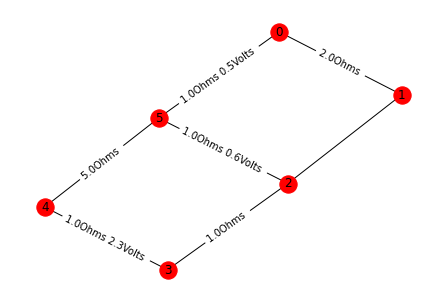

[0]---->[1]
[5]---->[0]
[1]---->[2]
[2]---->[5]
[3]---->[2]
[4]---->[3]
[5]---->[4]


In [24]:
kg2 = circuit_parser('circuit2.txt')
plot_kirchoffgraph(kg2)

In [25]:
find_kg_edges_weights(kg2)

array([[0.19032258],
       [0.19032258],
       [0.19032258],
       [0.52903226],
       [0.33870968],
       [0.33870968],
       [0.33870968]])